In [1]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import scipy.stats

import pickle
import methods.util as util
import methods.shared as shared
import methods.sim_barcodes as sim
from importlib import reload

In [2]:
tech_replicates = 0
tech_replicates_vivo = 0
samples = 0

for library, reps in shared.library_array_map.items():
    if len(library) == 3 and library[-1] == 0:
        continue
    if len(library) == 3 and library[0] == 'E2' and type(library[1]) == int and library[1] > 10 and library[-1] == 14:
        continue
    if library[-1] == 'smallint':
        continue
    samples += 1
    if len(reps) > 1:
        print(library, reps)
        tech_replicates += 1
    if len(reps) > 1 and 'vivo' in reps[0]:
        tech_replicates_vivo += 1
print(samples)
print(tech_replicates)
print(tech_replicates_vivo)
    

('E1', 1, 3) [('vivo', 27), ('reseq', 0)]
('E1', 2, 3) [('vivo', 28), ('reseq', 1)]
('E1', 3, 3) [('vivo', 29), ('reseq', 2)]
('E1', 4, 3) [('vivo', 30), ('reseq', 3)]
('E1', 9, 3) [('vivo', 32), ('reseq', 7)]
('E1', 10, 3) [('vivo', 33), ('reseq', 8)]
('E1', 11, 3) [('vivo', 34), ('reseq', 9)]
('E1', 12, 3) [('vivo', 35), ('reseq', 10)]
('E1', 13, 3) [('vivo', 36), ('reseq', 11)]
('E1', 2, 4) [('vivo', 37), ('reseq', 13)]
('E1', 8, 4) [('vivo', 41), ('reseq', 16)]
('E1', 9, 4) [('vivo', 42), ('reseq', 17)]
('E1', 10, 4) [('vivo', 43), ('reseq', 18)]
('E1', 11, 4) [('vivo', 44), ('reseq', 19)]
('E1', 1, 5) [('vivo', 45), ('reseq', 22)]
('E1', 2, 5) [('vivo', 46), ('reseq', 23)]
('E1', 3, 5) [('vivo', 47), ('reseq', 24)]
('E1', 5, 5) [('vivo', 49), ('reseq', 25)]
('E1', 8, 5) [('vivo', 52), ('reseq', 26)]
('E1', 9, 5) [('vivo', 53), ('reseq', 27)]
('E1', 12, 5) [('vivo', 54), ('reseq', 30)]
('E1', 1, 6) [('vivo', 55), ('reseq', 31)]
('E1', 2, 6) [('vivo', 56), ('reseq', 32)]
('E1', 3, 6

In [3]:
## Summary of high-frequency, high-fitness barcodes 
reload(shared)
expt = 'E1'
fit_barcodes = {}
mouse_specific_high_frequency_barcodes = {}

mice_in_each_col = [(1,2,3,4,5), (6,7,8,9,10), (11,12,13)]
init_day, fin_day = 9, 15

SD_growth_rates = {}
MD_growth_rates = {}

day9_freqs_SD = []
day9_freqs_MD = []
day9_entropy_SD = []
day9_entropy_MD = []


for col, (m_set, colors, title) in enumerate( zip(mice_in_each_col, ['Blues', 'Oranges', 'Reds'], ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    for single_mouse in m_set:
        ## for revision
        large_indices_before_3weeks = shared.find_large_barcodes(expt, [single_mouse], max_cutoff=1e-2, final_cutoff=1, max_timepoint=21)
        print(f'Mouse {single_mouse}: sampled {len(large_indices_before_3weeks)} high frequency barcodes')
        #get day9 freqs among these large_indices
        days, reads, depths = shared.get_mouse_timecourse(expt, single_mouse, min_depth=10**4)
        freqs = shared.calc_freqs(reads, depths)
        ref_day = 14
        try: 
            day9_freqs = freqs[np.where(days==ref_day)[0][0]]
            if single_mouse < 11:
                day9_freqs_SD.append(day9_freqs[large_indices_before_3weeks].sum())
                day9_entropy_SD.append(shared.calc_entropy([day9_freqs])[0])
            else:
                day9_freqs_MD.append(day9_freqs[large_indices_before_3weeks].sum())
                day9_entropy_MD.append(shared.calc_entropy([day9_freqs])[0])
            print(f'Mouse {single_mouse}: sampeld on day {ref_day}')
            
        except:
            pass


       

        large_indices= shared.find_large_barcodes(expt, [single_mouse], max_cutoff=1e-2, final_cutoff=1)
        mouse_specific_high_frequency_barcodes[single_mouse] = large_indices
        #### record high frequency barcodes in each mouse
        for barcode in shared.barcodes[large_indices]:
            if barcode not in fit_barcodes:
                fit_barcodes[barcode] = []
            fit_barcodes[barcode].append(single_mouse)

        ### estimate exponential growth rates
        if single_mouse in [4,5,6,7]:  ###  exclude cross-housed mice
            continue
        if single_mouse in [1,2,3,8,9,10]:
            diet_growth_rates = SD_growth_rates
        elif single_mouse in [11,12,13]:
            diet_growth_rates = MD_growth_rates


        # days, rows, cec = shared.mouse_meta[expt][single_mouse]
        # freqs, Deff = shared.freq_array[rows], shared.Deff_array[rows]

        days, reads, depths = shared.get_mouse_timecourse(expt, single_mouse, min_depth=10**3)
        freqs = shared.calc_freqs(reads, depths)


        # fig, ax = plt.subplots()
        for barcode_idx in large_indices:
            barcode = shared.barcodes[barcode_idx]
            bc_freqs = freqs[:,barcode_idx]
            
            final_idx = np.where(bc_freqs > 10**-2)[0][0]
            try:
                init_idx = np.where(bc_freqs[:final_idx] < 10**-3)[0][-1]
            except:
                init_idx = 0

            t0, t1 = days[init_idx], days[final_idx]
            if t1 > 21:
                continue
            dt = t1-t0

            _, reads, [D0, D1] = shared.get_mouse_timecourse(expt, single_mouse, specific_timepoints=[t0, t1])
            f0,f1 = shared.calc_freqs(reads, np.array([D0, D1]))
            mm_f0, mm_f1 = shared.maxmin_freqs([f0[barcode_idx]], D0, [f1[barcode_idx]], D1)

            growth_rate = np.log(mm_f1/mm_f0)[0]/dt
            if barcode not in diet_growth_rates:
                diet_growth_rates[barcode] = []
            diet_growth_rates[barcode].append((single_mouse, growth_rate, (t0,t1), (f0*D0,f1*D1)))
            
        #     if growth_rate > 1:
        #         ax.plot(days, bc_freqs)
        # # ax.set_yscale('log')

SD_lst, MD_lst = [], []
for (diet, filtered_lst, diet_growth_rates) in [('SD', SD_lst, SD_growth_rates), ('MD', MD_lst, MD_growth_rates)]:
    for b, (barcode, bc_growths) in enumerate(diet_growth_rates.items()):
        growth_rates = np.array([g[1] for g in bc_growths]) 
        if len(growth_rates) == 0: continue
        filtered_lst.append(np.median(growth_rates)) # append the smallest fitness, for barcodes with estimates in multiple mice


    print(f'Diet {diet}: num_high_freq barcodes (>1%):', len(filtered_lst))
    print('List of growth rates:', [float(f'{g:.2f}') for g in filtered_lst])
    print('Min, max growth rate in first 3 weeks (/day):', f'{np.min(filtered_lst):.2f}, {np.max(filtered_lst):.2f}')
    print('25th, median, 75th percentile:', f'{np.percentile(filtered_lst, 25):.2f}, {np.median(filtered_lst):.2f}, {np.percentile(filtered_lst, 75):.2f}')
    print('\n')

MD_lst, SD_lst = np.array(MD_lst), np.array(SD_lst)
print('1-sided Mann Whitney test for MD > SD growths', scipy.stats.mannwhitneyu(MD_lst, SD_lst, alternative='greater'))

for mouse in mouse_specific_high_frequency_barcodes:
    print(f'Mouse {mouse}: {len(mouse_specific_high_frequency_barcodes[mouse])} high frequency barcodes')
    print('List of barcodes:', [shared.barcodes[b] for b in mouse_specific_high_frequency_barcodes[mouse]])

with open(f'../data/pickled/E1_large_barcodes.pkl', 'wb') as f:
    pickle.dump(fit_barcodes, f)



Mouse 1: sampled 12 high frequency barcodes
Mouse 1: sampeld on day 14
Mouse 2: sampled 11 high frequency barcodes
Mouse 2: sampeld on day 14
Mouse 3: sampled 13 high frequency barcodes
Mouse 3: sampeld on day 14
Mouse 4: sampled 18 high frequency barcodes
Mouse 4: sampeld on day 14
Mouse 5: sampled 19 high frequency barcodes
Mouse 5: sampeld on day 14
Mouse 6: sampled 13 high frequency barcodes
Mouse 6: sampeld on day 14
Mouse 7: sampled 11 high frequency barcodes
Mouse 8: sampled 18 high frequency barcodes
Mouse 8: sampeld on day 14
Mouse 9: sampled 13 high frequency barcodes
Mouse 9: sampeld on day 14
Mouse 10: sampled 9 high frequency barcodes
Mouse 10: sampeld on day 14
Mouse 11: sampled 9 high frequency barcodes
Mouse 11: sampeld on day 14
Mouse 12: sampled 10 high frequency barcodes
Mouse 12: sampeld on day 14
Mouse 13: sampled 15 high frequency barcodes
Diet SD: num_high_freq barcodes (>1%): 65
List of growth rates: [0.22, 0.48, 2.19, 0.16, 0.73, 0.28, 0.64, 0.42, 0.46, 0.48, 0

In [4]:
print( scipy.stats.ttest_ind([np.mean(day9_freqs_SD[:5]), np.mean(day9_freqs_SD[5:])], [np.mean(day9_freqs_MD)], equal_var=True) )
SD1_mean, SD2_mean = np.mean(day9_freqs_SD[:5]), np.mean(day9_freqs_SD[5:])
SD_mean = np.mean([SD1_mean, SD2_mean])
SD_std = np.std([SD1_mean, SD2_mean], ddof=1)
MD_mean = np.mean(day9_freqs_MD)
print(MD_mean, SD1_mean, SD2_mean, SD_mean, SD_std)
all_std = np.std([SD1_mean, SD2_mean, MD_mean], ddof=1)
all_mean = np.mean([SD1_mean, SD2_mean, MD_mean])

tval = (MD_mean - SD_mean)/(SD_std)
print(tval)
print(1-scipy.stats.t.cdf(tval, df=1))
# print(1-scipy.stats.norm.cdf(tval))

Ttest_indResult(statistic=nan, pvalue=nan)
0.689105011989857 0.30259023057630857 0.4439776825051236 0.3732839565407161 0.09997602603355212
3.158967884392112
0.0975869815851318


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_25957/1744490828.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print( scipy.stats.ttest_ind([np.mean(day9_freqs_SD[:5]), np.mean(day9_freqs_SD[5:])], [np.mean(day9_freqs_MD)], equal_var=True) )
/Users/daniel/.conda/envs/wu_barcodes_clean/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/daniel/.conda/envs/wu_barcodes_clean/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [5]:
print( scipy.stats.ttest_ind([np.mean(day9_entropy_SD[:5]), np.mean(day9_entropy_SD[5:])], [np.mean(day9_entropy_MD)], equal_var=True) )
SD1_mean, SD2_mean = np.mean(day9_entropy_SD[:5]), np.mean(day9_entropy_SD[5:])
SD_mean = np.mean([SD1_mean, SD2_mean])
SD_std = np.std([SD1_mean, SD2_mean], ddof=1)
MD_mean = np.mean(day9_entropy_MD)
print(MD_mean, SD1_mean, SD2_mean, SD_mean, SD_std)
all_std = np.std([SD1_mean, SD2_mean, MD_mean], ddof=1)
all_mean = np.mean([SD1_mean, SD2_mean, MD_mean])

tval = (MD_mean - SD_mean)/(SD_std)
print(tval)
print(scipy.stats.t.cdf(tval, df=1))

Ttest_indResult(statistic=nan, pvalue=nan)
2.0565921389425386 5.508451134731558 4.305867354022342 4.907159244376951 0.8503551462844428
-3.3522077427175363
0.09228007706095742


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_25957/2243136600.py:1: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print( scipy.stats.ttest_ind([np.mean(day9_entropy_SD[:5]), np.mean(day9_entropy_SD[5:])], [np.mean(day9_entropy_MD)], equal_var=True) )


1 25 [ 0  1  2  3  4  5  6  7  9 12 14 15 16 17 18 19 20 21 22 27 29 33 36 40
 54]
2 23 [ 0  1  2  3  4  5  6  7  9 12 14 15 16 18 19 20 21 22 27 29 33 40 54]
3 23 [ 0  1  2  3  4  5  6  7  9 12 14 15 17 18 19 20 21 22 29 33 36 40 54]
8 28 [ 0  1  2  3  4  5  6  7  9 12 14 15 16 17 18 19 20 21 27 29 33 36 40 45
 46 47 48 54]
9 25 [ 0  1  2  3  4  5  6  7  9 12 14 16 17 18 19 20 21 22 27 33 36 40 47 48
 54]
10 23 [ 0  1  2  3  4  5  6  7  9 12 14 16 17 18 19 20 22 29 33 40 46 48 54]
11 20 [ 0  1  2  3  4  6  9 12 14 15 16 17 18 19 20 22 27 29 33 51]
12 20 [ 0  1  2  3  4  5  6  7  9 12 14 15 16 17 19 20 27 29 40 51]
13 14 [ 0  2  3  4  6  9 15 17 19 20 21 27 29 40]
0
Num barcodes considered for lfc calculation in SD (P2), mouse 1: 8707 	 83.8% of input barcodes, freq range = (2.67e-05, 5.65e-04)
0
Num barcodes considered for lfc calculation in SD (P2), mouse 2: 8707 	 83.8% of input barcodes, freq range = (2.67e-05, 5.65e-04)
0
Num barcodes considered for lfc calculation in SD (P2), mou

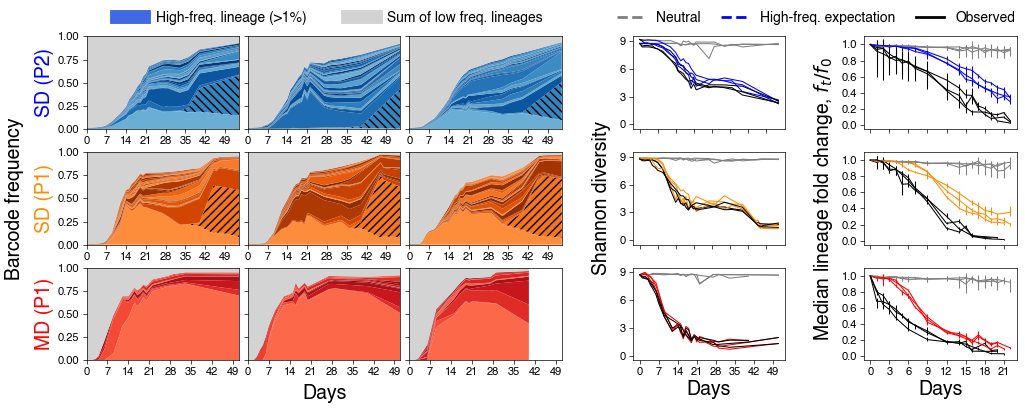

In [10]:
reload(shared)
expt = 'E1'

fig = plt.figure(figsize=(12, 4.5))
all_gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[0.1, 3], width_ratios=(3.5, 2.5), hspace=0.07, figure=fig)

#grid subspec for muller axes from all_gs
outer = all_gs[1, :].subgridspec(nrows=3, ncols=7, wspace=0.07, hspace=0.25, width_ratios=(1,1,1,0.35,1,0.4,1))
# outer = mpl.gridspec.GridSpec(nrows=4, ncols=7, wspace=0.05, hspace=0.25, height_ratios=[0.1, 1, 1, 1], width_ratios=(1,1,1,0.5,1,0.5,1), figure=fig)
outer_ax = fig.add_subplot(outer[:, :3])
outer_ax.set_xlabel('Days', fontsize=14, labelpad=17)
outer_ax.set_ylabel('Barcode frequency', fontsize=14, labelpad=45)
util.turn_off_ax(outer_ax)

legend_ax = fig.add_subplot(all_gs[0,0])
util.turn_off_ax(legend_ax)
legend_markers = [ mpl.lines.Line2D((0,), (0,), color='royalblue',  linestyle='solid', lw=10),
                    mpl.lines.Line2D((0,), (0,), color='lightgrey', linestyle='solid', lw=10),]
legend_ax.legend(legend_markers, ['High-freq. lineage (>1%)', 'Sum of low freq. lineages'] , loc=(0.05, -0.5), ncol=2, frameon=False, fontsize=10, columnspacing=3)


mean_fitness_traj = {}

mice_in_each_row = [(1,2,3), (8,9,10), (11,12,13)]

muller_colors = {'SD (P2)':'blue', 'SD (P1)':'darkorange', 'MD (P1)':'red'}
for row, (mice_set, colormaps, title) in enumerate( zip(mice_in_each_row, 

                                                  [(('P2', 'Blues'), ('P1', 'Oranges'), ('E1_shared', 'Greys'), ('E1_ambiguous', 'Greys')),
                                                   (('P2', 'Blues'), ('P1', 'Oranges'), ('E1_shared', 'Greys'), ('E1_ambiguous', 'Greys')),
                                                   (('P2', 'Reds'), ('P1', 'Reds'), ('E1_shared', 'Greys'), ('E1_ambiguous', 'Greys'))], 
                                                   
                                                  ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    large_indices = shared.find_large_barcodes(expt, mice_set, max_cutoff=1e-2, final_cutoff=2)

    
    ordered_indices, ordered_colors = shared.order_barcodes_by_pool(large_indices, shared.barcode_pool_assignments,
                                                                     colormaps, cg_at_end=True, cg_all_low_freqs=True)
    for col, mouse in enumerate(mice_set):
        days, freqs = shared.make_muller_freqs(expt, mouse, ordered_indices, 18, min_depth=10**4)
        print(mouse, len(days), days)
        ax = fig.add_subplot(outer[row, col])
        shared.muller_plot(ax, days, ordered_indices, freqs, ordered_colors, shared.highlight_barcode_hatches)

        if 'format':
            ax.set_ylim(0, 1)
            ax.set_xlim(0, 54)
            ax.set_xticks([0, 7, 14, 21, 28, 35, 42, 49])
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

            #reduce spine thickness
            ax.spines['top'].set_linewidth(0.5)
            ax.spines['right'].set_linewidth(0.5)
            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            #orient ax ticks out
            ax.tick_params(axis='x', direction='out', width=0.5, length=3)
            ax.tick_params(axis='y', direction='out', width=0.5, length=3)

            if row == 2:
                ax.set_xlim(0, 51)
            if col == 0:
                ax.set_ylabel(title, color=muller_colors[title], fontsize=14, labelpad=3)
            if col > 0:
                ax.set_yticklabels([])

### Entropy column
legend_ax = fig.add_subplot(all_gs[0, 1])
util.turn_off_ax(legend_ax)
legend_markers = [
                    mpl.lines.Line2D((0,), (0,), color='grey', linestyle='dashed', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='blue', linestyle='dashed', lw=2),
                    mpl.lines.Line2D((0,), (0,), color='black', mfc='None', markersize=4, lw=2)]
legend_ax.legend(legend_markers, ['Neutral', 'High-freq. expectation', 'Observed'], loc=(-0.15, -0.5), ncol=3, frameon=False, fontsize=10, columnspacing=1.5)


entropy_outer = fig.add_subplot(outer[:, 4])
util.turn_off_ax(entropy_outer)
entropy_outer.set_ylabel('Shannon diversity', fontsize=14, labelpad=16)
entropy_outer.set_xlabel('Days', fontsize=14, labelpad=14)

median_fc_outer = fig.add_subplot(outer[:, 6])
util.turn_off_ax(median_fc_outer)
# median_fc_outer.set_ylabel('Median fold change (mean fitness)', fontsize=14)
median_fc_outer.set_ylabel('Median lineage fold change, $f_t/f_0$', fontsize=14, labelpad=21)
median_fc_outer.set_xlabel('Days', fontsize=14, labelpad=14)

min_freq = 0
Ntau = 10**6 #days
MIN_GROUP_SIZE = 30
for z, (m_set, colors, inoc_bool, title) in enumerate( zip(mice_in_each_row, 
                                                ['blue', 'darkorange', 'red'],
                                                [shared.barcode_pool_assignments['P2'][1], shared.barcode_pool_assignments['P1'][1], shared.barcode_pool_assignments['P1'][1]],
                                                ['SD (P2)', 'SD (P1)', 'MD (P1)']) ):
    entropy_ax = fig.add_subplot(outer[z, 4])
    ax = fig.add_subplot(outer[z, 6])


    for m, mouse in enumerate(m_set):
        # days = shared.mouse_meta['E1'][mouse][0]
        # rows = shared.mouse_meta['E1'][mouse][1]

        # plot_days = np.array(days)
        # plot_rows = np.array(rows)
        
        # mouse_freqs = shared.freq_array[plot_rows]
        # mouse_depths = shared.Deff_array[plot_rows]

        plot_days, mouse_reads, mouse_depths = shared.get_mouse_timecourse(expt, mouse)
        mouse_freqs = shared.calc_freqs(mouse_reads, mouse_depths)
        print(plot_days[0])



        mouse_large_entropies = shared.calc_entropy(mouse_freqs, min_freq=min_freq)

        neutral_sim_frequencies = sim.neutral_sim(mouse_freqs[0], Ntau, plot_days, mouse_depths)
        expected_neutral_entropies = shared.calc_entropy(neutral_sim_frequencies, min_freq=min_freq)

        high_frequency_expected_freqs = shared.high_frequency_expectation(plot_days, mouse_freqs, 
                                                                          mouse_specific_high_frequency_barcodes[mouse], mouse_depths, Ntau=Ntau) 
        
        expected_large_entropies = shared.calc_entropy(high_frequency_expected_freqs, min_freq=min_freq)

        
        large_Deff = ((mouse_depths > 10**4) | ( (plot_days >= 14) & (mouse_depths > 10**3))) #plot entropy points with sufficient sequencing depth
        entropy_ax.plot(plot_days[large_Deff], expected_neutral_entropies[large_Deff], color='grey', linestyle='solid', zorder=0)
        entropy_ax.plot(plot_days[large_Deff], expected_large_entropies[large_Deff], color=colors, linestyle='solid', alpha=1)
        entropy_ax.plot(plot_days[large_Deff], mouse_large_entropies[large_Deff], color='black', linestyle='solid')

    

        ## Group barcodes by initial frequency for fold-change plot
        # day0_reads = shared.read_array[plot_rows[0]]
        # day0_freqs = shared.freq_array[plot_rows[0]]
        day0_reads = mouse_reads[0]
        day0_freqs = mouse_freqs[0]
        barcode_groups = []
        barcode_ranges = []


        # lower = MIN_READS
        # lower = np.percentile(day0_reads[inoc_bool][day0_reads[inoc_bool] > 0], 50)
        # MAX_READS = np.percentile(day0_reads[inoc_bool][day0_reads[inoc_bool] > 0], 99.9)
        lower = np.percentile(day0_reads[inoc_bool], 75)
        max_reads = np.percentile(day0_reads[inoc_bool], 99.9)


        input_total_represented = np.sum(day0_freqs[inoc_bool][ (day0_reads[inoc_bool] > lower) & (day0_reads[inoc_bool] < max_reads)])

        upper = lower * 1.1
        
        while upper < max_reads:
            indices = np.where( (day0_reads >= lower) & (day0_reads < upper) )[0]
            if len(indices) < MIN_GROUP_SIZE:
                upper *= 1.1
                continue
            barcode_ranges.append( (lower, upper) )
            lower = upper
            upper = lower * 1.1
            barcode_groups.append(indices)

        min_freq, max_freq = np.min(barcode_ranges)/day0_reads.sum(), np.max(barcode_ranges)/day0_reads.sum()
        print( f'Num barcodes considered for lfc calculation in {title}, mouse {mouse}:', np.sum([len(g) for g in  barcode_groups]), f'\t {input_total_represented*100:.1f}% of input barcodes, freq range = ({min_freq:.2e}, {max_freq:.2e})' )

        for freqs, color, ls in zip([neutral_sim_frequencies, high_frequency_expected_freqs, mouse_freqs], 
                                    ['grey', colors, 'black'], 
                                    ['solid', 'solid', 'solid']):
        # for freqs, color, ls in zip([neutral_sim_frequencies, high_frequency_expected_freqs], ['grey', colors, 'black'], ['dashed', 'dashed', 'solid']):
            median_lfcs = shared.calc_median_lfc(freqs, mouse_depths, barcode_groups=barcode_groups)
            x, y, yerr = [0], [1], [[0, 0]]
            for day, depth, median_lfcs_in_groups in zip(plot_days[1:], mouse_depths[1:], median_lfcs):
                if day > 25 or len(median_lfcs_in_groups) < 4 or depth < 10**4:
                    continue

                medians = [median for (median, group_lfcs) in median_lfcs_in_groups]
                lfcs = [group_lfcs for (median, group_lfcs) in median_lfcs_in_groups]
                # print(mouse, day, np.median(medians), np.sum([len(l) for l in lfcs]))

                median_of_medians = np.exp(np.median(medians))
                quartiles = np.exp([np.percentile(medians, 25), np.percentile(medians, 75)])
                deltas = [median_of_medians- quartiles[0], quartiles[1] - median_of_medians]

                x.append(day)
                y.append(median_of_medians)
                yerr.append(deltas)
            
            ax.errorbar(x, y, yerr=np.transpose(yerr), color=color, ls=ls)
            if color == 'black':
                mean_fitness_traj[mouse] = (x, y, yerr)

    if 'format':
        entropy_ax.set_ylim(-0.5, 9.5)
        entropy_ax.set_xticks([0,7,14,21,28,35,42,49])
        entropy_ax.set_yticks([0, 3, 6, 9])

        ax.set_ylim(-0.05, 1.1)
        ax.set_xlim(-1, 23)
        ax.set_xticks([0,3,6,9,12,15,18,21])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        #orient ax ticks out
        entropy_ax.tick_params(axis='x', direction='out', width=0.5, length=3)
        entropy_ax.tick_params(axis='y', direction='out', width=0.5, length=3)
        ax.tick_params(axis='x', direction='out', width=0.5, length=3)
        ax.tick_params(axis='y', direction='out', width=0.5, length=3)

        ax.spines['top'].set_linewidth(0.5)
        ax.spines['right'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)

        entropy_ax.spines['top'].set_linewidth(0.5)
        entropy_ax.spines['right'].set_linewidth(0.5)
        entropy_ax.spines['bottom'].set_linewidth(0.5)
        entropy_ax.spines['left'].set_linewidth(0.5)

        if z != 2:
            ax.set_xticklabels([])
            entropy_ax.set_xticklabels([])
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig(f'../figures/fig1_E1_muller.pdf', bbox_inches='tight', transparent=True, dpi=300)
fig.savefig(f'../figures/fig1_E1_muller.svg', bbox_inches='tight', transparent=True, dpi=300)

In [7]:
with open(f'../data/pickled/E1_mean_fitness_traj.pkl', 'wb') as f:
    pickle.dump(mean_fitness_traj, f)

In [ ]:
## reviewer comments